Note: based on: https://github.com/arsena-k/discourse_atoms/blob/master/DATM%20Tutorial%20Part%201%20of%201%20-%20Identifying%20Atoms%20-%20for%20Public.ipynb

# Discourse Atom Topic Modeling (DATM) Tutorial 

## Part 1 of 2: Extract Atoms from Word Embedding Trained on your Text Data

* This code is written in Python 3.7.2, and uses Gensim version 3.8.3. 
* This code is provides an the outline of how we identified topics in a word embedding trained on our cleaned data, and then explored the resultings topics. Note that we cannot redistribute the data used in our paper "Integrating Topic Modeling and Word Embedding" in any form, and researchers must apply directly to the Centers for Disease Control and Prevention for access. Details on data access are provided in the paper. We add comments with tips for adapting this code to your data. 

In [2]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 


from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

## Input: Word2Vec model Trained on your Text Data

* Below, we use a public, and free word2vec model pretrained on Google News to illustrate how to identify and explore atom vectors in a trained embedding space. [To download the model, click here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)

In [3]:
currentmodel = KeyedVectors.load('./models/gensim_model_window10_vector_300')

datm_folder = './datm/'
#change to the working directory where you downloaded your model #in this tutorial, we're limiting the w2v model to the top 40k words for efficienc

## Extract Atoms with K-SVD

In [4]:
def do_aksvd(w2vmodel, n_comp, n_nonzeros,  savelocation, save=False ):
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #n_components is number of discourse atoms, if vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms.
    gamma_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the gammas, which are the "weights" of each word on a discourse atoms
    #len(dictionary[0]) #check that a discourse-atom vector is still same dimensions as word-vectors, note that norm of the dictionary vecs (atoms) are each 1! 
    if save==True:
        outfile = open(str(savelocation)  + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation)  +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary' ,'wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation)  + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_gamma','wb')
        pickle.dump(gamma_t,outfile)
        outfile.close()
    return(dictionary_t, gamma_t)


Sample usage:

In [21]:
#mydictionary, mygamma = do_aksvd(currentmodel, 500, 5,  datm_folder,  save=False) #200 topics, each word can be a linear combo of 5 topics

## Evaluate Internal Model Quality

* Using coherence, topic diversity, sse, rmse, or $r^2$
* These functions are imported from quality .py file, above, see code in this .py file or [paper](https://arxiv.org/abs/2106.14365) for details on these functions

In [22]:
print('Coherence (pairwise):', coherence_pairwise(currentmodel, mydictionary, top_n=25))

print('Topic Diversity:', topic_diversity(currentmodel, mydictionary, top_n=25))

print('SSE, RMSE, R2:', reconst_qual(currentmodel, mydictionary, mygamma))

Coherence (pairwise): 0.41755396
Topic Diversity: 0.80448
SSE, RMSE, R2: (3169649.53997197, 0.471537155211288, 0.5606967897560392)


Coherence (pairwise): 0.4617589
Topic Diversity: 0.9562
SSE, RMSE, R2: (282498.41000679834, 0.15343250687919166, 0.4359828777277901)

Select the number of hyperparameters (e.g., number of atoms and/or number of nonzeros) by training models on a range of these hyperparameters and using quality metrics to select the best model

In [5]:
ntopics= []
nonzeros = []
cohere_pairwise= []
div=[]
sse= []
rmse =[]
r2=[]


for i in [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 325, 400, 600, 800, 1000]: 
    for j in [5]: # Arora and A-K both choose 5
        dictionary, gamma = do_aksvd(currentmodel, i, j, datm_folder,  save=True) #varying hyperparameters
        cohere_pairwise.append(coherence_pairwise(currentmodel, dictionary, top_n=25))
        div.append(topic_diversity(currentmodel, dictionary, top_n=25))
        rec= reconst_qual(currentmodel, dictionary, gamma)
        sse.append(rec[0])
        rmse.append(rec[1])
        r2.append(rec[2])
        ntopics.append(i)
        nonzeros.append(j)

In [7]:
quality_results = pd.DataFrame(data={'Components_Topics': ntopics,'Nonzeros': nonzeros,
                'CohereCossim_top25_mean': cohere_pairwise, 'Diversity_top25': div, 
                  'SSE': sse,'RMSE': rmse, 'R2': r2})

In [23]:
quality_results

,Components_Topics,Nonzeros,CohereCossim_top25_mean,Diversity_top25,SSE,RMSE,R2
0,25,5,0.431077,1.000000,5.176687e+06,0.602610,0.282528
1,50,5,0.449306,0.995200,4.669629e+06,0.572337,0.352804
2,75,5,0.465869,0.984000,4.415711e+06,0.556558,0.387997
3,100,5,0.458013,0.986800,4.234200e+06,0.544999,0.413153
4,125,5,0.458369,0.975360,4.072867e+06,0.534516,0.435514
5,150,5,0.454880,0.972533,3.956675e+06,0.526836,0.451618
6,175,5,0.445931,0.968686,3.847838e+06,0.519540,0.466702
7,200,5,0.439877,0.952400,3.765282e+06,0.513936,0.478144
8,225,5,0.435794,0.939200,3.649732e+06,0.505989,0.494159
9,250,5,0.425429,0.934560,3.601023e+06,0.502601,0.500910


[(0.0, 1.0)]

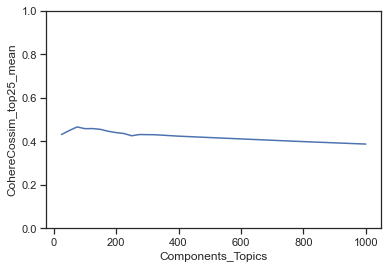

In [20]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="CohereCossim_top25_mean", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# Higher coherence is better; more interpretable for humans.

[(0.0, 1.0)]

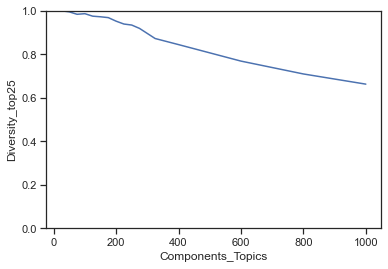

In [21]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="Diversity_top25", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# THe higher the value, the less overlap there is between topics. 200 or 250 topics seems best

[(0.0, 1.0)]

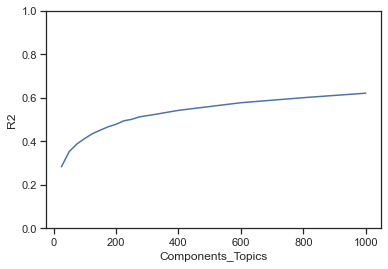

In [22]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="R2", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# Marginal gains seem to flatten after 275

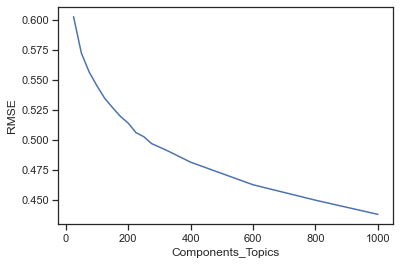

In [18]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="RMSE", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
#plt.set(ylim=(.67, .85))
#plt.set(xlim=(0,550))

# Again 250ish seems where marginal gains get lower

## Exploring the Model and Resulting Topics

In [24]:
infile = open('./datm/250comp5nonzeros_dictionary','rb')
mydictionary=pickle.load(infile)
infile.close()

Exploring the 25 most similar words to each atom atom and their respective cosine similarities (note that here is where you get a "topic": the distribution of words that characterize an atom vector

In [25]:
for i in range(0, len(mydictionary)): 
    print("Discourse_Atom " + str(i))
    print([j for j in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the 25 most similar words to the Nth dicourse atom?
    print('\n')

Discourse_Atom 0
[('brigading', 0.7345764636993408), ('reddit', 0.7256457805633545), ('r/movies', 0.7252709865570068), ('/r/movies', 0.7252132296562195), ('downvotes', 0.6935362219810486), ('circlejerk', 0.6835670471191406), ('butthurt', 0.6720367074012756), ('downvoted', 0.6603800058364868), ('contrarian', 0.659785270690918), ('downvoting', 0.6535385847091675), ('upvoted', 0.6530286073684692), ('circlejerking', 0.6487492322921753), ('negative', 0.6478844881057739), ('subreddit', 0.6423874497413635), ('opinions', 0.6420949101448059), ('r/starwars', 0.6323381662368774), ('hyperbole', 0.6301425695419312), ('downvote', 0.6245441436767578), ('incels', 0.6227434277534485), ('criticism', 0.6196122765541077), ('sjws', 0.6120769381523132), ('critics', 0.6090151071548462), ('haters', 0.6070846319198608), ('astroturfing', 0.6049184799194336), ('t_d', 0.6044037342071533)]


Discourse_Atom 1
[('present', 0.6194867491722107), ('timeline', 0.5932822227478027), ('2023', 0.5869277715682983), ('future'

[('allotted', 0.7538145780563354), ('waster', 0.7383823990821838), ('elapsed', 0.7268394231796265), ('millionth', 0.6966816186904907), ('traveler', 0.6862647533416748), ('constraint', 0.6809974312782288), ('non-linearity', 0.680618166923523), ('loooooong', 0.6791155338287354), ('vortexes', 0.6748924255371094), ('travellers', 0.6747726202011108), ('umpteenth', 0.6734236478805542), ('dilation', 0.6733433604240417), ('travel', 0.6700475215911865), ('traveller', 0.6626349091529846), ('nonlinearly', 0.658602774143219), ('biding', 0.6574708819389343), ('wrinkle', 0.6573660373687744), ('wastes', 0.6506210565567017), ('non-linearly', 0.642043948173523), ('clobbering', 0.641362190246582), ('travelers', 0.6402937173843384), ('loooong', 0.6353223323822021), ('looooong', 0.6333073377609253), ('wasting', 0.6199048161506653), ('looong', 0.6189175248146057)]


Discourse_Atom 54
[('installed', 0.6741735935211182), ('wireless', 0.6673879623413086), ('computer', 0.662443995475769), ('database', 0.655316

[('franchise', 0.7010740041732788), ('reboot', 0.6817851662635803), ('starwars', 0.6788079142570496), ('sw', 0.6375222206115723), ('trilogy', 0.6372063159942627), ('series', 0.627764105796814), ('sequels', 0.6177103519439697), ('reboots', 0.6069153547286987), ('spinoffs', 0.5981597304344177), ('prequel', 0.5634161829948425), ('sequel', 0.5554102659225464), ('saga', 0.549850583076477), ('triology', 0.5454966425895691), ('spin-offs', 0.5418957471847534), ('disney', 0.540349543094635), ('gb', 0.5300092697143555), ('trilogies', 0.5271193385124207), ('rebooted', 0.5229832530021667), ('ff', 0.519939661026001), ('spin-off', 0.5139675140380859), ('mainline', 0.5130538940429688), ('dcu', 0.506426990032196), ('eu', 0.5063910484313965), ('franchises', 0.5042251944541931), ('remaking', 0.49903932213783264)]


Discourse_Atom 112
[('brought', 0.72393798828125), ('bringing', 0.6962712407112122), ('harkens', 0.6687812209129333), ('held', 0.6451472640037537), ('coming', 0.6270645260810852), ('harkened'

[('car', 0.7280465960502625), ('truck', 0.7153691649436951), ('motorcycle', 0.7028494477272034), ('jeep', 0.6921957731246948), ('bike', 0.6902496814727783), ('bmw', 0.6700617671012878), ('highway', 0.669722318649292), ('mercedes', 0.6591484546661377), ('suv', 0.6558698415756226), ('cab', 0.6558163166046143), ('trucks', 0.6514557003974915), ('cars', 0.6488310694694519), ('toyota', 0.6469364166259766), ('benz', 0.6214678287506104), ('mustang', 0.6201344132423401), ('freeway', 0.6197035908699036), ('getaway', 0.617195188999176), ('humvee', 0.6157053112983704), ('motorbike', 0.6099992394447327), ('subaru', 0.6097992062568665), ('limo', 0.6070591807365417), ('prius', 0.6031489968299866), ('convoy', 0.6004927158355713), ('convertible', 0.5962502956390381), ('tires', 0.5958391427993774)]


Discourse_Atom 171
[('wolverine', 0.8190741539001465), ('xavier', 0.8003292083740234), ('wolvie', 0.7677122950553894), ('logan', 0.757361114025116), ('magneto', 0.7571961879730225), ('cyclops', 0.7565319538

[('several', 0.8020696043968201), ('numerous', 0.792625904083252), ('multiple', 0.7874768376350403), ('countless', 0.7568619251251221), ('various', 0.7557144165039062), ('many', 0.7101881504058838), ('dozens', 0.634954035282135), ('these', 0.6172619462013245), ('those', 0.5985533595085144), ('plenty', 0.5967365503311157), ('lots', 0.5959303379058838), ('few', 0.5836442112922668), ('myriad', 0.5823177099227905), ('tons', 0.5646228790283203), ('couple', 0.5624161958694458), ('innumerable', 0.5562514066696167), ('two', 0.5555656552314758), ('multitude', 0.5490089654922485), ('hundreds', 0.5347733497619629), ('handful', 0.5341044664382935), ('half-dozen', 0.5328001976013184), ('three', 0.5324038863182068), ('*multiple*', 0.5252931118011475), ('3-4', 0.5190584659576416), ('bunch', 0.512946367263794)]


Discourse_Atom 232
[('finn', 0.7193138599395752), ('poe', 0.656646728515625), ('fin', 0.6456517577171326), ('finns', 0.6421300172805786), ('finn/rose', 0.6166011095046997), ('po', 0.584964990

#### Extract a Gender Dimension and Compute the Gender Loading of the Topics

In [26]:
manvec = np.mean([currentmodel.wv['male'],  currentmodel.wv['man'], currentmodel.wv['he'], currentmodel.wv['his'], currentmodel.wv['him'], currentmodel.wv['himself']], axis=0)
womanvec= np.mean([currentmodel.wv['female'],  currentmodel.wv['woman'], currentmodel.wv['she'], currentmodel.wv['hers'], currentmodel.wv['her'], currentmodel.wv['herself']], axis=0)

gendervec= normalize(womanvec.reshape(1, -1))-normalize(manvec.reshape(1, -1))

cossim_gender=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the most similar words to the ith discourse atom?
    print()
    print(cosine_similarity(gendervec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_gender.append(cosine_similarity(gendervec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    print()

Discourse_Atom 0
[('brigading', 0.7345764636993408), ('reddit', 0.7256457805633545), ('r/movies', 0.7252709865570068), ('/r/movies', 0.7252132296562195), ('downvotes', 0.6935362219810486), ('circlejerk', 0.6835670471191406), ('butthurt', 0.6720367074012756), ('downvoted', 0.6603800058364868), ('contrarian', 0.659785270690918), ('downvoting', 0.6535385847091675), ('upvoted', 0.6530286073684692), ('circlejerking', 0.6487492322921753), ('negative', 0.6478844881057739), ('subreddit', 0.6423874497413635), ('opinions', 0.6420949101448059), ('r/starwars', 0.6323381662368774), ('hyperbole', 0.6301425695419312), ('downvote', 0.6245441436767578), ('incels', 0.6227434277534485), ('criticism', 0.6196122765541077), ('sjws', 0.6120769381523132), ('critics', 0.6090151071548462), ('haters', 0.6070846319198608), ('astroturfing', 0.6049184799194336), ('t_d', 0.6044037342071533)]

[0.06368578]

Discourse_Atom 1
[('present', 0.6194867491722107), ('timeline', 0.5932822227478027), ('2023', 0.586927771568298

[('b-movie', 0.7143071889877319), ('romcom', 0.6793235540390015), ('pulpy', 0.6765393614768982), ('rom-com', 0.6701645255088806), ('slasher', 0.6672031879425049), ('scifi', 0.6614614725112915), ('sci-fi', 0.6612375974655151), ('shlock', 0.6531438231468201), ('blockbuster', 0.6443856358528137), ('schlock', 0.6406997442245483), ('genre', 0.6332560777664185), ('schlocky', 0.6210918426513672), ('horror/thriller', 0.6145098209381104), ('horror', 0.6127718687057495), ('comedy', 0.603239893913269), ('big-budget', 0.6009111404418945), ('thriller/horror', 0.5942622423171997), ('grindhouse', 0.5913769006729126), ('campy', 0.5912573933601379), ('typical', 0.590908944606781), ('blaxploitation', 0.5884294509887695), ('action-adventure', 0.5869240164756775), ('classic', 0.5822457671165466), ('flick', 0.577981173992157), ('subgenre', 0.5774904489517212)]

[0.05317621]

Discourse_Atom 45
[('approachable', 0.6752567887306213), ('efficient', 0.6704896688461304), ('nuanced', 0.6670933365821838), ('sophis


Discourse_Atom 90
[('disparity', 0.7313818335533142), ('differentiation', 0.7208278179168701), ('correlation', 0.7199488282203674), ('alternated', 0.711966872215271), ('discrepancy', 0.7064817547798157), ('distinction', 0.7002830505371094), ('schism', 0.6925917863845825), ('interplay', 0.6775408387184143), ('sandwiched', 0.6706178188323975), ('alternating', 0.6647453904151917), ('difference', 0.6546805500984192), ('divide', 0.6531128287315369), ('disconnect', 0.650928258895874), ('dichotomy', 0.646770715713501), ('differences', 0.6397354602813721), ('similarity', 0.6246557235717773), ('linkage', 0.6072356700897217), ('juxtaposition', 0.597356915473938), ('separation', 0.5968747735023499), ('gap', 0.5914229154586792), ('contrast', 0.5852822065353394), ('dissonance', 0.5811167359352112), ('rivalry', 0.5797591805458069), ('disparities', 0.5764886140823364), ('alternates', 0.5612635016441345)]

[-0.00554578]

Discourse_Atom 91
[('ever', 0.643291711807251), ('arguably', 0.6247230768203735)


[-0.04172823]

Discourse_Atom 137
[('wealthy', 0.7405983209609985), ('rich', 0.7194367051124573), ('impoverished', 0.7028789520263672), ('poverty', 0.6597012281417847), ('elites', 0.6465267539024353), ('wealth', 0.6438363790512085), ('underprivileged', 0.6270332336425781), ('capitalist', 0.6179438233375549), ('immigrants', 0.6151724457740784), ('capitalists', 0.6133301854133606), ('slaves', 0.6075719594955444), ('welfare', 0.6049694418907166), ('oppressed', 0.6014698147773743), ('privileged', 0.5988994836807251), ('downtrodden', 0.5986270308494568), ('farmers', 0.5975356698036194), ('families', 0.58856201171875), ('laborers', 0.5877752900123596), ('billionaires', 0.5838456749916077), ('destitute', 0.5821602940559387), ('middle-class', 0.5815361738204956), ('workers', 0.5772177577018738), ('upper-class', 0.5759568214416504), ('kims', 0.574859619140625), ('slums', 0.5708330273628235)]

[-0.05339201]

Discourse_Atom 138
[('hardly', 0.6404179930686951), ('barely', 0.5766235589981079), ('n


Discourse_Atom 184
[('leguizamo', 0.8620809316635132), ('wicks', 0.834109902381897), ('deere', 0.8327704071998596), ('stamos', 0.824419379234314), ('ratzenberger', 0.8150752186775208), ('krasinki', 0.8079743385314941), ('travolta', 0.7941164970397949), ('ambrose', 0.7812055945396423), ('bellairs', 0.7762448191642761), ('mulaney', 0.7717975974082947), ('lithgow', 0.7705617547035217), ('mcclane', 0.7659165859222412), ('cenas', 0.7657442092895508), ('amos', 0.7652533054351807), ('turturro', 0.7590059638023376), ('scher', 0.7573487162590027), ('boyegas', 0.7534137964248657), ('cusack', 0.7434974908828735), ('cassavetes', 0.7426538467407227), ('ottman', 0.7356142401695251), ('malkovich', 0.7329558730125427), ('wick', 0.7286953926086426), ('conner', 0.7228043675422668), ('lennon', 0.7220833897590637), ('denver', 0.7199450135231018)]

[-0.07931659]

Discourse_Atom 185
[('structure', 0.5474984049797058), ('contrivances', 0.5233795642852783), ('overarching', 0.5105504989624023), ('cohesiveness

[0.00199385]

Discourse_Atom 229
[('avengers', 0.7483392953872681), ('hulk', 0.7199863195419312), ('thor', 0.7113573551177979), ('endgame', 0.6930902600288391), ('iw', 0.6862968802452087), ('thanos', 0.6860305070877075), ('cap', 0.6805915832519531), ('ironman', 0.6790651082992554), ('wanda', 0.6573116183280945), ('antman', 0.6392101645469666), ('aou', 0.6382311582565308), ('tony', 0.6310043931007385), ('ant-man', 0.6258641481399536), ('loki', 0.6230161190032959), ('hawkeye', 0.6211504936218262), ('stark', 0.616528332233429), ('mcu', 0.6076967120170593), ('warmachine', 0.6070413589477539), ('iron-man', 0.600669264793396), ('banner', 0.5959132313728333), ('spidey', 0.5813167095184326), ('spiderman', 0.5787069201469421), ('rhodey', 0.5773623585700989), ('im2', 0.5769473910331726), ('bw', 0.5659827589988708)]

[-0.14975928]

Discourse_Atom 230
[('young', 0.6482412219047546), ('highschool', 0.6329575181007385), ('teenager', 0.6318961381912231), ('hs', 0.6133478283882141), ('teacher', 0.6125

In [27]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether on the feminine or masculine side)
zippes= zip( cossim_gender, [i for i in range(0, len(mydictionary))]) #get most fem/masc
sorted(zippes)

[(array([-0.34980118], dtype=float32), 68),
 (array([-0.29301667], dtype=float32), 141),
 (array([-0.28897488], dtype=float32), 173),
 (array([-0.2468688], dtype=float32), 78),
 (array([-0.23956029], dtype=float32), 126),
 (array([-0.23792094], dtype=float32), 227),
 (array([-0.221816], dtype=float32), 107),
 (array([-0.20687497], dtype=float32), 117),
 (array([-0.19716607], dtype=float32), 212),
 (array([-0.18246901], dtype=float32), 52),
 (array([-0.17819692], dtype=float32), 25),
 (array([-0.17318885], dtype=float32), 218),
 (array([-0.15669926], dtype=float32), 29),
 (array([-0.15248984], dtype=float32), 8),
 (array([-0.14975928], dtype=float32), 229),
 (array([-0.14856769], dtype=float32), 202),
 (array([-0.14140262], dtype=float32), 110),
 (array([-0.13801862], dtype=float32), 103),
 (array([-0.132104], dtype=float32), 102),
 (array([-0.13055986], dtype=float32), 142),
 (array([-0.12987034], dtype=float32), 96),
 (array([-0.12554403], dtype=float32), 237),
 (array([-0.12374517], 

In [ ]:
#write results to CSV

genderedlevels= pd.DataFrame(np.concatenate( cossim_gender, axis=0 ), columns= ['gendered_connotation'])
genderedlevels.to_csv('gendered_connotations_of_topics.csv')

In [38]:
currentmodel.wv.most_similar(positive='white')

[("'white", 0.6709594130516052),
 ('non-black', 0.6256055235862732),
 ('non-white', 0.5685011148452759),
 ('asian', 0.5598679780960083),
 ('hispanic', 0.550437867641449),
 ('latino', 0.547042191028595),
 ('black', 0.5405596494674683),
 ('whites', 0.52195143699646),
 ('nonwhite', 0.5178133249282837),
 ('muslim', 0.5092766284942627)]

#### Extract an Indoor/Outdoor Dimension and Compute the Loading of the Topics on this Dimension

In [40]:
indoorvec = np.mean([currentmodel.wv['racism'],  currentmodel.wv['black'] , currentmodel.wv['discrimination']], axis=0)
outdoorvec= np.mean([currentmodel.wv['white'], currentmodel.wv['non-black']], axis=0)

indooroutdoorvec= normalize(indoorvec.reshape(1, -1))-normalize(outdoorvec.reshape(1, -1))

cossim_indout=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=15)]) #what are the most similar words to the Nth dicourse atom?
    print(cosine_similarity(indooroutdoorvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_indout.append(cosine_similarity(indooroutdoorvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    #print('\n')

Discourse_Atom 0
['seen', 'heard', 'read', 'posted', 'watched', 'commented', 'noticed', 'seen/heard', 'read/watched', 'responded', 'experienced', 'mentioned', 'replied', 'quoted', 'encountered']
[-0.03710248]
Discourse_Atom 1
['wb', 'studio', 'paramount', 'execs', 'sony', 'executives', 'lucasfilm', 'disney', 'studios', 'warner', 'producers', 'whedon', 'trank', 'snyder', 'synder']
[0.05712799]
Discourse_Atom 2
['people', 'folks', 'ppl', 'redditors', 'moviegoers', 'viewers', 'reviewers', 'americans', 'goers', 'fans', 'others', 'nerds', 'folk', 'teenagers', 'christians']
[0.11372389]
Discourse_Atom 3
['yourself', 'you', 'myself', 'yourselves', 'themselves', 'ourselves', '*you*', 'your', 'youre', 'them', 'u', 'people', 'reddit', 'viewer', 'oneself']
[0.20010395]
Discourse_Atom 4
['progressive', 'contemporary', 'prevalent', 'inclusive', 'normalized', 'problematic', 'pervasive', 'conservative', 'commonplace', 'liberal', 'harmful', 'generalized', 'political', 'marginalized', 'reactionary']
[0

[0.19618905]
Discourse_Atom 46
['humor', 'slapstick', 'humour', 'one-liners', 'quips', 'comedy', 'jokes', 'gags', 'snark', 'banter', 'irreverent', 'goofiness', 'witty', 'comedic', 'quippy']
[0.10118419]
Discourse_Atom 47
['walking', 'walk', 'walks', 'crawling', 'hanging', 'ran', 'walked', 'floated', 'peeking', 'sneaking', 'crawled', 'crawls', 'running', 'sneaks', 'hops']
[-0.0565282]
Discourse_Atom 48
['snowy', 'beneath', 'icy', 'underneath', 'sand', 'fog', 'water', 'mountains', 'collapsing', 'splashing', 'marshes', 'atop', 'submerged', 'forests', 'flooding']
[-0.01712419]
Discourse_Atom 49
['wealthy', 'rich', 'elites', 'capitalists', 'businesses', 'billionaires', 'corporations', 'institutions', 'impoverished', 'corrupt', 'capitalist', 'wealth', 'unions', 'greedy', 'politicians']
[-0.0225573]
Discourse_Atom 50
['physical', 'tangible', 'natural', 'non-human', 'innate', 'human', 'metaphysical', 'human-like', 'fantastical', 'mystical', 'otherworldly', 'unique', 'intangible', 'spiritual', 

['25', '36', '35', '55', '120', '33', '115', '53', '50+', '44', '~25', '38', '130', '40', '19']
[-0.03306751]
Discourse_Atom 94
['knowledge', 'patience', 'decency', 'understanding', 'self-awareness', 'appreciation', 'familiarity', 'education', 'experience', 'morals', 'respect', 'vocabulary', 'confidence', 'experiences', 'hangups']
[0.1108856]
Discourse_Atom 95
['negates', 'invalidates', 'ruined', 'undermines', 'ruins', 'invalidated', 'undercuts', 'derailed', 'cheapens', 'disregards', 'inconsequential', 'cheapened', 'ignored', 'superfluous', 'pointless']
[-0.06295054]
Discourse_Atom 96
['yt', 'facebook', 'website', 'instagram', 'laptop', 'app', 'youtube', 'roku', 'nbc', 'itunes', 'npr', 'twitter', 'hulu', 'monitors', 'news']
[0.0200359]
Discourse_Atom 97
['several', 'numerous', 'multiple', 'countless', 'many', 'few', 'couple', 'dozens', 'plenty', 'various', 'handful', 'lots', 'tons', 'zillion', 'half-dozen']
[-0.01660069]
Discourse_Atom 98
['woody', 'forky', 'bonnie', 'bo', 'forkie', 't

['desk', 'table', 'porch', 'chair', 'ledge', 'tree', 'statue', 'shoulder', 'couch', 'balcony', 'ceiling', 'roof', 'rooftop', 'wall', 'floor']
[-0.00817747]
Discourse_Atom 142
['rescue', 'reinforcements', 'back', 'allies', 'siberia', 'supplies', 'retrieve', 'safety', 'flee', 'fleeing', 'chopper', 'evac', 'intel', 'presumably', 'mission']
[0.02254215]
Discourse_Atom 143
['understands', 'hates', 'loves', 'knows', 'sees', 'likes', 'thinks', 'believes', 'recognizes', 'appreciates', 'acknowledges', 'remembers', 'considers', 'gives', 'is']
[-0.0743517]
Discourse_Atom 144
['demon', 'demonic', 'paimon', 'annie', 'annies', 'witchcraft', 'satanic', 'voodoo', 'charlies', 'sketchbook', 'occult', 'treehouse', 'possessed', 'headless', 'grandmothers']
[-0.08798711]
Discourse_Atom 145
['temper', '1v1', 'opponent', 'emo', 'overconfident', 'rage', 'tantrums', 'tantrum', 'brawler', 'brute', 'vader', 'beat', 'chokes', 'fists', 'ragdoll']
[-0.02276443]
Discourse_Atom 146
['great', 'decent', 'solid', 'good',

[0.03624949]
Discourse_Atom 195
['venom', 'symbiote', 'brock', 'cletus', 'eddie', 'carnage', 'eddy', 'symbiotes', 'kasady', 'symbiosis', 'venoms', 'kassidy', 'shriek', 'brock/venom', 'izzard']
[0.06201964]
Discourse_Atom 196
['portion', 'chunk', 'majority', 'rest', 'remainder', '2/3', 'portions', 'bulk', 'entirety', '2/3rds', '3/4', '1/3', '3/4ths', 'part', 'chunks']
[0.04964562]
Discourse_Atom 197
['across', 'back', 'down', 'out', 'bicycle', 'fishing', 'outta', 'grass', 'boulder', 'whered', 'mountain', 'barefoot', 'handy', 'accross', 'impaled']
[-0.07873415]
Discourse_Atom 198
['protruding', 'prosthetic', 'severed', 'pierced', 'amputated', 'twitching', 'torso', 'licking', 'slashed', 'pointy', 'socket', 'slicing', 'swollen', 'puncture', 'sliced']
[-0.02082376]
Discourse_Atom 199
['grim', 'bleak', 'realistic', 'depressing', 'brutal', 'disturbing', 'somber', 'frightening', 'tame', 'nihilistic', 'violent', 'horrifying', 'poignant', 'surreal', 'gruesome']
[0.03428723]
Discourse_Atom 200
['

[0.12546914]
Discourse_Atom 245
['complaint', 'gripe', 'nitpick', 'problem', 'issue', 'downside', 'complaints', 'drawback', 'gripes', 'flaw', 'plothole', 'quibble', 'criticism', 'problems', 'qualm']
[0.04493338]
Discourse_Atom 246
['rewatch', 're-watch', 'rewatching', 'blu-ray', 'bluray', 'viewings', 'viewing', 'rewatches', 'dvd', 're-watching', 'blu', 'watch', 'redbox', 'dvd/bluray', 'vod']
[0.13361575]
Discourse_Atom 247
['she', 'carol', 'diana', 'cheetah', 'herself', 'her', 'ww', 'danvers', 'mulan', 'antiope', 'cara', 'actress', 'scarjo', 'raya', 'chloe']
[-0.02858077]
Discourse_Atom 248
['tolerate', 'handle', 'comprehend', 'relate', 'fathom', 'resist', 'predict', 'tell', 'attest', 'pinpoint', 'conceive', 'discern', 'deny', 'unsee', 'detect']
[-0.03945169]
Discourse_Atom 249
['leguizamo', 'wicks', 'stamos', 'deere', 'lithgow', 'ratzenberger', 'krasinki', 'conner', 'cenas', 'travolta', 'mcclane', 'mulaney', 'amos', 'turturro', 'ambrose']
[-0.00514363]
Discourse_Atom 250
['toyed', 'sy

[0.12396157]
Discourse_Atom 292
['pummeled', 'rekt', 'offed', 'shafted', 'axed', 'obliterated', 'mauled', 'mugged', 'demolished', 'shredded', 'ambushed', 'punked', 'devoured', 'annihilated', 'wrecked']
[-0.13744125]
Discourse_Atom 293
['abilities', 'strength', 'intellect', 'capabilities', 'skill', 'prowess', 'mastery', 'skills', 'ability', 'agility', 'toughness', 'durability', 'dexterity', 'reflexes', 'capability']
[0.17100257]
Discourse_Atom 294
['lets', "'ll", 'will', 'let', 'theyll', 'imma', 'ill', 'ima', 'itll', 'letting', "'d", 'youll', 'can', 'ta', 'gunna']
[-0.04229871]
Discourse_Atom 295
['blacking', 'blacked', 'singling', 'nerding', 'petered', 'blurts', 'blurt', 'scoping', 'pussied', 'well-thought', 'chickened', 'copped', 'lashed', 'dishing', 'singled']
[-0.00835021]
Discourse_Atom 296
['clunky', 'contrived', 'hamfisted', 'ham-fisted', 'disjointed', 'sloppy', 'unfocused', 'rushed', 'choppy', 'tacky', 'messy', 'corny', 'overdone', 'cringy', 'melodramatic']
[0.00740622]
Discours

['melody', 'orchestral', 'music', 'orchestra', 'song', 'vocals', 'yorke', 'instrumentals', 'synth', 'guitar', 'ost', 'violin', 'thom', 'percussion', 'acoustic']
[-0.01759197]
Discourse_Atom 338
['bulbs', 'strobe', 'fluorescent', 'bulb', 'glow', 'flickering', 'bathed', 'heartedness', 'blinding', 'bright', 'yellow', 'hue', 'uv', 'glows', 'tint']
[-0.06713157]
Discourse_Atom 339
['linear', 'non-linear', 'nonlinear', 'deterministic', 'predetermined', 'linearly', 'altering', 'non-linearly', 'unfold', 'diverging', 'causality', 'changing', 'altered', 'forwards', 'branching']
[0.07026002]
Discourse_Atom 340
['fight', 'battle', 'fights', 'fighting', '1v1', 'battles', 'showdown', 'duel', 'fought', 'vs', 'rematch', 'brawl', 'one-on-one', 'defeating', 'battling']
[0.08860413]
Discourse_Atom 341
['sword', 'lightsaber', 'axe', 'knife', 'saber', 'pistol', 'lightsabre', 'hammer', 'spear', 'axes', 'stormbreaker', 'blades', 'swords', 'mjolnir', 'gun']
[0.0395131]
Discourse_Atom 342
['eggsy', 'merlin', '

['jangly', 'polka-dot', 'slender', 'repo', 'aw', 'aqua', 'amphibious', "'iron", 'polkadot', 'rubberband', 'wicker', 'aww', 'iron', 'maketh', 'marshmallow']
[-0.16869406]
Discourse_Atom 386
['techniques', 'technique', 'technology', 'skill', 'tactics', 'filmmaking', 'technologies', 'skills', 'innovation', 'craft', 'methods', 'craftsmanship', 'tools', 'weaponry', 'creativity']
[0.20843558]
Discourse_Atom 387
['he', 'leo', 'arvin', 'hoffa', 'him', 'jesse', 'fitzgerald', 'emmett', 'slj', 'ethan', 'winslow', 'arno', 'fitz', 'roy', 'georgie']
[0.12955975]
Discourse_Atom 388
['widescreen', '4k', 'hdr', '35mm', '70mm', '2.35:1', 'imax', '16:9', 'non-imax', '3d', '120fps', 'hfr', 'digital', '24fps', '1080p']
[0.05306394]
Discourse_Atom 389
['skilled', 'trained', 'combatant', 'fighter', 'mma', 'melee', 'hand-to-hand', 'veteran', 'hardened', 'combat', 'seasoned', 'warrior', 'swordsman', 'ufc', 'marksman']
[-0.04942083]
Discourse_Atom 390
['sattler', 'ritter', 'zaius', 'ling', 'chen', 'moreau', 'se

['infantry', 'spears', 'weapons', 'weaponry', 'rifles', 'armored', 'blasters', 'firepower', 'artillery', 'archers', 'armoured', 'melee', 'armed', 'guerilla', 'turrets']
[0.03644609]
Discourse_Atom 439
['identical', 'opposites', 'halves', 'separate', 'different', 'seperate', 'both', 'popes', 'interchangeable', 'same', 'respectively', 'sherlocks', 'distinct', 'clashing', 'similar']
[-0.08981208]
Discourse_Atom 440
['bittersweet', 'cliffhanger', 'happy', 'hopeful', 'triumphant', 'downer', 'ending', "'happy", 'bitter', 'feel-good', 'sad', 'uplifting', 'bleak', 'depressing', 'whimper']
[0.03516823]
Discourse_Atom 441
['goro', 'kang', 'sub-zero', 'raiden', 'subzero', 'outworld', 'kano', 'scorpion', 'liu', 'jax', 'mileena', 'sonya', 'hanzo', 'bi-han', 'tsung']
[0.06234103]
Discourse_Atom 442
['hulu', 'itunes', 'netflix', 'vod', 'dvd', 'dvd/blu-ray', 'hbomax', 'hbo', 'streaming', 'bluray', 'blu-ray', 'disney+', 'peacock', 'youtube', 'dvd/bluray']
[0.04064599]
Discourse_Atom 443
['thousands', '

[-0.12275218]
Discourse_Atom 492
['behaving', 'behave', 'treating', 'treats', 'immoral', 'self-centered', 'treated', 'narcissistic', 'heartless', 'sociopathic', 'psychopathic', 'treat', 'unsympathetic', 'mistreated', 'autistic']
[-0.14426664]
Discourse_Atom 493
['hallway', 'house', 'apartment', 'bedroom', 'garage', 'basement', 'barn', 'hallways', 'warehouse', 'kitchen', 'room', 'mansion', 'lobby', 'staircase', 'bathroom']
[-0.08613968]
Discourse_Atom 494
['hes', 'theyre', 'youre', 'shes', 'isnt', 'its', 'thats', 'im', 'theres', 'arent', 'wasnt', 'whats', 'is', 'whos', 'theyve']
[0.06489377]
Discourse_Atom 495
['tracker', 'vial', 'coordinates', 'gps', 'necklace', 'plutonium', 'map', 'detonator', 'vault', 'location', 'chopper', 'codes', 'usb', 'transmitter', 'intel']
[-0.06486788]
Discourse_Atom 496
['consciousness', 'immortality', 'regained', 'conciousness', 'temporarily', 'regain', 'reality', 'permanently', 'transfers', 'healing', 'subconscious', 'restored', 'regaining', 'existence', '

In [41]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether indoor or outdoor)
zippes= zip( cossim_indout, [i for i in range(0, len(mydictionary))]) 
sorted(zippes)

[(array([-0.30038846]), 382),
 (array([-0.24205252]), 155),
 (array([-0.21886356]), 232),
 (array([-0.21838565]), 7),
 (array([-0.20949047]), 390),
 (array([-0.20882351]), 181),
 (array([-0.20429897]), 65),
 (array([-0.18793331]), 64),
 (array([-0.18391212]), 42),
 (array([-0.18045171]), 10),
 (array([-0.17826794]), 169),
 (array([-0.17552298]), 281),
 (array([-0.17370931]), 377),
 (array([-0.16958294]), 348),
 (array([-0.16869406]), 385),
 (array([-0.15569601]), 208),
 (array([-0.15281107]), 35),
 (array([-0.14974951]), 110),
 (array([-0.14520431]), 422),
 (array([-0.14426664]), 492),
 (array([-0.14110979]), 260),
 (array([-0.13846397]), 243),
 (array([-0.13745515]), 78),
 (array([-0.13744125]), 292),
 (array([-0.13446472]), 104),
 (array([-0.1304926]), 420),
 (array([-0.12838108]), 120),
 (array([-0.12791799]), 29),
 (array([-0.12700188]), 124),
 (array([-0.12655565]), 183),
 (array([-0.12400127]), 32),
 (array([-0.12369069]), 150),
 (array([-0.12275218]), 491),
 (array([-0.12273798]

In [ ]:
#write results to CSV

indoutlevels= pd.DataFrame(np.concatenate( cossim_indout, axis=0 ), columns= ['indooroutdoor_connotation'])
indoutlevels.to_csv('indout_connotations_of_topics.csv')